# Gesture Recognition
In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

# Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up: Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds
- Stop: Pause the movie

Each video is a sequence of 30 frames (or images)

# Understanding the Dataset

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

The data is divided into a 'train' and a 'val' folder with two CSV files for the two folders.

In [2]:
import numpy as np
import os
import datetime
import abc
from sys import getsizeof
import imageio # alternative to imread as it is deprecated
from PIL import Image # alternative of imread as it is deprecated
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from skimage.io import imread

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [6]:
import cv2

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [8]:
project_folder='datasets/Project_data'

##### Plotting

In [9]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
class ModelBuilder(metaclass= abc.ABCMeta):

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs


    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))


                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=resize(cropped,(self.image_height,self.image_width,3))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here we make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [11]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

2023-07-08 10:10:10.297388: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-08 10:10:10.297462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

##### Sample Cropping

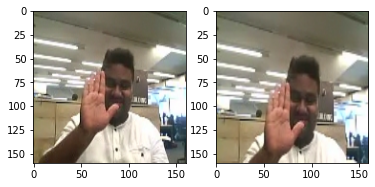

In [13]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

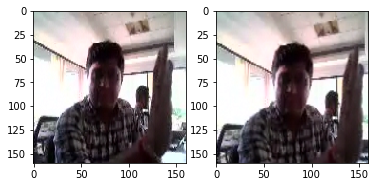

## Experimenting with Image resolution, number of frames to use and batch_size

In [14]:
conv_3d1.train_model(conv_3d1_model)

2023-07-08 10:10:24.833739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.5360 - categorical_accuracy: 0.4691
Epoch 00001: saving model to model_init_2023-07-0810_10_11.745165/model-00001-1.53597-0.46908-3.08332-0.16000.h5
17/17 [==============================] - 181s 11s/step - loss: 1.5360 - categorical_accuracy: 0.4691 - val_loss: 3.0833 - val_categorical_accuracy: 0.1600 - lr: 0.0010


### The Categorical accuracy and the validation accuracy is too low. Let's experiment further to get models with better accuracy

##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5602 - categorical_accuracy: 0.4465
Epoch 00001: saving model to model_init_2023-07-0810_13_23.077510/model-00001-1.56019-0.44646-2.56132-0.22000.h5
23/23 [==============================] - 95s 4s/step - loss: 1.5602 - categorical_accuracy: 0.4465 - val_loss: 2.5613 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.8981 - categorical_accuracy: 0.6501
Epoch 00002: saving model to model_init_2023-07-0810_13_23.077510/model-00002-0.89807-0.65008-4.83778-0.23000.h5
23/23 [==============================] - 94s 4s/step - loss: 0.8981 - categorical_accuracy: 0.6501 - val_loss: 4.8378 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.6554 - categorical_accuracy: 0.7572
Epoch 00003: saving model to model_init_2023-07-0810_13_23.077510/model-00003-0.65542-0.75716-6.42171-0.2

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.5508 - categorical_accuracy: 0.4344
Epoch 00001: saving model to model_init_2023-07-0810_18_08.001117/model-00001-1.55081-0.43439-2.19300-0.16000.h5
23/23 [==============================] - 156s 7s/step - loss: 1.5508 - categorical_accuracy: 0.4344 - val_loss: 2.1930 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.9971 - categorical_accuracy: 0.6184
Epoch 00002: saving model to model_init_2023-07-0810_18_08.001117/model-00002-0.99710-0.61840-4.09681-0.12000.h5
23/23 [==============================] - 155s 7s/step - loss: 0.9971 - categorical_accuracy: 0.6184 - val_loss: 4.0968 - val_categorical_accuracy: 0.1200 - lr: 0.0010


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6803 - categorical_accuracy: 0.3846 
Epoch 00001: saving model to model_init_2023-07-0810_23_24.933509/model-00001-1.68033-0.38462-1.71449-0.21000.h5
12/12 [==============================] - 157s 14s/step - loss: 1.6803 - categorical_accuracy: 0.3846 - val_loss: 1.7145 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.1499 - categorical_accuracy: 0.5535 
Epoch 00002: saving model to model_init_2023-07-0810_23_24.933509/model-00002-1.14991-0.55354-2.91837-0.22000.h5
12/12 [==============================] - 148s 13s/step - loss: 1.1499 - categorical_accuracy: 0.5535 - val_loss: 2.9184 - val_categorical_accuracy: 0.2200 - lr: 0.0010


In [19]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.5376 - categorical_accuracy: 0.4133
Epoch 00001: saving model to model_init_2023-07-0810_28_42.507389/model-00001-1.53757-0.41327-1.57007-0.22000.h5
12/12 [==============================] - 85s 8s/step - loss: 1.5376 - categorical_accuracy: 0.4133 - val_loss: 1.5701 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.0580 - categorical_accuracy: 0.5943
Epoch 00002: saving model to model_init_2023-07-0810_28_42.507389/model-00002-1.05799-0.59427-1.87980-0.17000.h5
12/12 [==============================] - 81s 7s/step - loss: 1.0580 - categorical_accuracy: 0.5943 - val_loss: 1.8798 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.7272 - categorical_accuracy: 0.3922
Epoch 00001: saving model to model_init_2023-07-0810_31_34.356078/model-00001-1.72722-0.39216-1.72785-0.16000.h5
9/9 [==============================] - 85s 10s/step - loss: 1.7272 - categorical_accuracy: 0.3922 - val_loss: 1.7278 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.0631 - categorical_accuracy: 0.5882
Epoch 00002: saving model to model_init_2023-07-0810_31_34.356078/model-00002-1.06314-0.58824-2.51729-0.18000.h5
9/9 [==============================] - 76s 9s/step - loss: 1.0631 - categorical_accuracy: 0.5882 - val_loss: 2.5173 - val_categorical_accuracy: 0.1800 - lr: 0.0010


In [21]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4613 - categorical_accuracy: 0.4223
Epoch 00001: saving model to model_init_2023-07-0810_34_23.980072/model-00001-1.46134-0.42232-6.88330-0.21000.h5
45/45 [==============================] - 176s 4s/step - loss: 1.4613 - categorical_accuracy: 0.4223 - val_loss: 6.8833 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0269 - categorical_accuracy: 0.5867
Epoch 00002: saving model to model_init_2023-07-0810_34_23.980072/model-00002-1.02690-0.58673-18.54036-0.16000.h5
45/45 [==============================] - 177s 4s/step - loss: 1.0269 - categorical_accuracy: 0.5867 - val_loss: 18.5404 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5954 - categorical_accuracy: 0.4133
Epoch 00001: saving model to model_init_2023-07-0810_40_20.490953/model-00001-1.59535-0.41327-3.04007-0.24000.h5
45/45 [==============================] - 96s 2s/step - loss: 1.5954 - categorical_accuracy: 0.4133 - val_loss: 3.0401 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9734 - categorical_accuracy: 0.6380
Epoch 00002: saving model to model_init_2023-07-0810_40_20.490953/model-00002-0.97340-0.63801-7.38806-0.17000.h5
45/45 [==============================] - 94s 2s/step - loss: 0.9734 - categorical_accuracy: 0.6380 - val_loss: 7.3881 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [23]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6933 - categorical_accuracy: 0.3967
Epoch 00001: saving model to model_init_2023-07-0810_43_32.785353/model-00001-1.69332-0.39668-3.52305-0.16000.h5
45/45 [==============================] - 83s 2s/step - loss: 1.6933 - categorical_accuracy: 0.3967 - val_loss: 3.5230 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0888 - categorical_accuracy: 0.5867
Epoch 00002: saving model to model_init_2023-07-0810_43_32.785353/model-00002-1.08879-0.58673-5.60617-0.16000.h5
45/45 [==============================] - 81s 2s/step - loss: 1.0888 - categorical_accuracy: 0.5867 - val_loss: 5.6062 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5452 - categorical_accuracy: 0.4299
Epoch 00001: saving model to model_init_2023-07-0810_46_18.638765/model-00001-1.54516-0.42986-3.01435-0.18000.h5
67/67 [==============================] - 82s 1s/step - loss: 1.5452 - categorical_accuracy: 0.4299 - val_loss: 3.0144 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.0911 - categorical_accuracy: 0.5777
Epoch 00002: saving model to model_init_2023-07-0810_46_18.638765/model-00002-1.09109-0.57768-2.91466-0.17000.h5
67/67 [==============================] - 82s 1s/step - loss: 1.0911 - categorical_accuracy: 0.5777 - val_loss: 2.9147 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [25]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5554 - categorical_accuracy: 0.4344
Epoch 00001: saving model to model_init_2023-07-0810_49_04.148390/model-00001-1.55540-0.43439-6.38700-0.21000.h5
67/67 [==============================] - 155s 2s/step - loss: 1.5554 - categorical_accuracy: 0.4344 - val_loss: 6.3870 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1580 - categorical_accuracy: 0.5701
Epoch 00002: saving model to model_init_2023-07-0810_49_04.148390/model-00002-1.15802-0.57014-9.15899-0.23000.h5
67/67 [==============================] - 154s 2s/step - loss: 1.1580 - categorical_accuracy: 0.5701 - val_loss: 9.1590 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [26]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5916 - categorical_accuracy: 0.4359
Epoch 00001: saving model to model_init_2023-07-0810_54_15.368507/model-00001-1.59155-0.43590-5.68359-0.23000.h5
67/67 [==============================] - 183s 3s/step - loss: 1.5916 - categorical_accuracy: 0.4359 - val_loss: 5.6836 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.0087 - categorical_accuracy: 0.6410
Epoch 00002: saving model to model_init_2023-07-0810_54_15.368507/model-00002-1.00867-0.64103-11.12432-0.24000.h5
67/67 [==============================] - 176s 3s/step - loss: 1.0087 - categorical_accuracy: 0.6410 - val_loss: 11.1243 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [27]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5684 - categorical_accuracy: 0.4480
Epoch 00001: saving model to model_init_2023-07-0811_00_16.725980/model-00001-1.56838-0.44796-7.27906-0.16000.h5
67/67 [==============================] - 96s 1s/step - loss: 1.5684 - categorical_accuracy: 0.4480 - val_loss: 7.2791 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.0313 - categorical_accuracy: 0.5943
Epoch 00002: saving model to model_init_2023-07-0811_00_16.725980/model-00002-1.03128-0.59427-10.19314-0.17000.h5
67/67 [==============================] - 93s 1s/step - loss: 1.0313 - categorical_accuracy: 0.5943 - val_loss: 10.1931 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.5632 - categorical_accuracy: 0.4042
Epoch 00001: saving model to model_init_2023-07-0811_03_26.555366/model-00001-1.56323-0.40422-1.94254-0.21000.h5
17/17 [==============================] - 98s 6s/step - loss: 1.5632 - categorical_accuracy: 0.4042 - val_loss: 1.9425 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.8451 - categorical_accuracy: 0.6682
Epoch 00002: saving model to model_init_2023-07-0811_03_26.555366/model-00002-0.84509-0.66817-2.20763-0.23000.h5
17/17 [==============================] - 95s 6s/step - loss: 0.8451 - categorical_accuracy: 0.6682 - val_loss: 2.2076 - val_categorical_accuracy: 0.2300 - lr: 0.0010


##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [29]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_84 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [31]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5389 - categorical_accuracy: 0.4118
Epoch 00001: saving model to model_init_2023-07-0811_06_44.412748/model-00001-1.53892-0.41176-1.66492-0.26000.h5
17/17 [==============================] - 124s 8s/step - loss: 1.5389 - categorical_accuracy: 0.4118 - val_loss: 1.6649 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9698 - categorical_accuracy: 0.6395
Epoch 00002: saving model to model_init_2023-07-0811_06_44.412748/model-00002-0.96981-0.63952-2.07900-0.21000.h5
17/17 [==============================] - 123s 8s/step - loss: 0.9698 - categorical_accuracy: 0.6395 - val_loss: 2.0790 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6805 - categorical_accuracy: 0.7406
Epoch 00003: saving model to model_init_2023-07-0811_06_44.412748/model-00003-0.68046-0.74057-2.6546

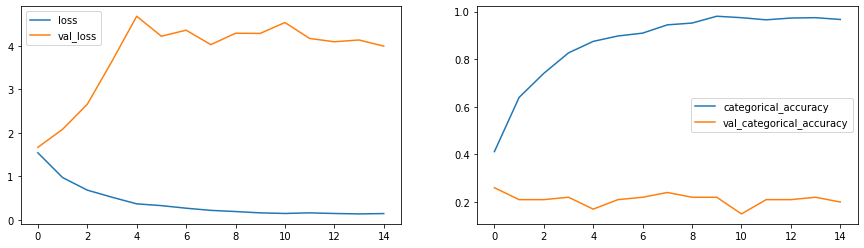

In [32]:
plot(history_model1)

##### Model is clearly overfitting as the training accuracy is high, however the validation accuracy is very low. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [33]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_90 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_61 (Activation)  (None, 10, 80, 80, 32)  

In [34]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0738 - categorical_accuracy: 0.3756
Epoch 00001: saving model to model_init_2023-07-0811_42_32.972058/model-00001-2.07384-0.37557-2.79349-0.17000.h5
34/34 [==============================] - 228s 7s/step - loss: 2.0738 - categorical_accuracy: 0.3756 - val_loss: 2.7935 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5651 - categorical_accuracy: 0.4653
Epoch 00002: saving model to model_init_2023-07-0811_42_32.972058/model-00002-1.56513-0.46531-4.59609-0.18000.h5
34/34 [==============================] - 223s 7s/step - loss: 1.5651 - categorical_accuracy: 0.4653 - val_loss: 4.5961 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2955 - categorical_accuracy: 0.5354
Epoch 00003: saving model to model_init_2023-07-0811_42_32.972058/model-00003-1.29548-0.53544-6.1674

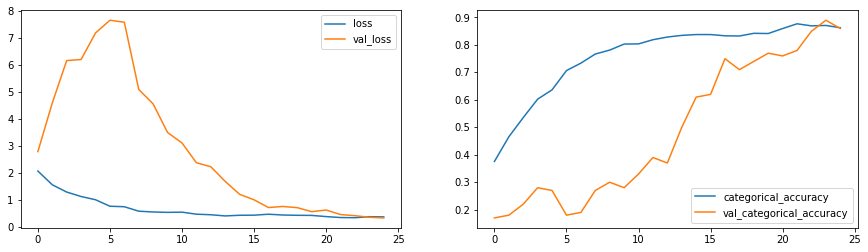

In [35]:
plot(history_model2)

##### Model is not overfitting and we get a best validation & training accuracy of 86%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [11]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2023-07-08 14:13:04.969185: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-08 14:13:04.969248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [13]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30


2023-07-08 14:13:17.434702: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.1101 - categorical_accuracy: 0.3326
Epoch 00001: saving model to model_init_2023-07-0814_13_09.820828/model-00001-2.11010-0.33258-1.94420-0.16000.h5
23/23 [==============================] - 155s 7s/step - loss: 2.1101 - categorical_accuracy: 0.3326 - val_loss: 1.9442 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.3752 - categorical_accuracy: 0.5181
Epoch 00002: saving model to model_init_2023-07-0814_13_09.820828/model-00002-1.37518-0.51810-3.37186-0.15000.h5
23/23 [==============================] - 149s 7s/step - loss: 1.3752 - categorical_accuracy: 0.5181 - val_loss: 3.3719 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.1695 - categorical_accuracy: 0.6101
Epoch 00003: saving model to model_init_2023-07-0814_13_09.820828/model-00003-1.16948-0.61011-4.43599-0.17000.h5
23/23 [=====

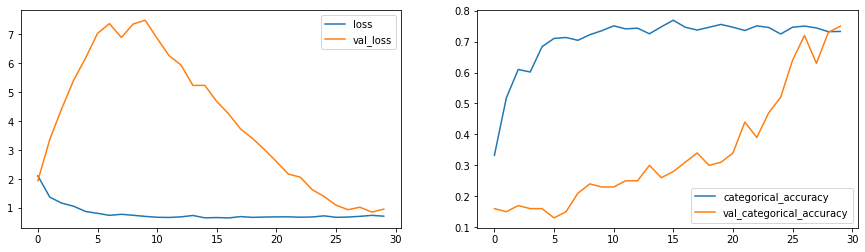

In [14]:
plot(history_model3)

##### Model has a validation accuracy of 75% and training accuracy of 73% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [12]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

2023-07-09 10:22:39.411740: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-09 10:22:39.411828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

In [14]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30


2023-07-09 10:22:55.448986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.9502 - categorical_accuracy: 0.3627
Epoch 00001: saving model to model_init_2023-07-0910_22_47.197976/model-00001-1.95021-0.36275-2.41984-0.21000.h5
34/34 [==============================] - 187s 5s/step - loss: 1.9502 - categorical_accuracy: 0.3627 - val_loss: 2.4198 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6729 - categorical_accuracy: 0.4314
Epoch 00002: saving model to model_init_2023-07-0910_22_47.197976/model-00002-1.67287-0.43137-2.61585-0.27000.h5
34/34 [==============================] - 149s 5s/step - loss: 1.6729 - categorical_accuracy: 0.4314 - val_loss: 2.6159 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4432 - categorical_accuracy: 0.4887
Epoch 00003: saving model to model_init_2023-07-0910_22_47.197976/model-00003-1.44321-0.48869-1.99286-0.40000.h5
34/34 [=============

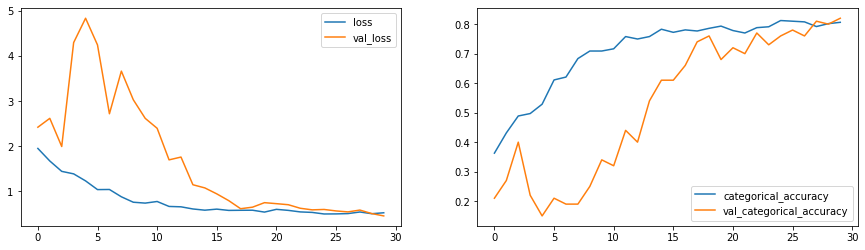

In [15]:
plot(history_model4)

##### With more layers we notice a decent performance improvement. We get a best validation accuracy of 82% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [16]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_9 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [18]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.6665 - categorical_accuracy: 0.4201
Epoch 00001: saving model to model_init_2023-07-0911_40_32.445439/model-00001-1.66653-0.42006-2.33830-0.16000.h5
34/34 [==============================] - 151s 5s/step - loss: 1.6665 - categorical_accuracy: 0.4201 - val_loss: 2.3383 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.3760 - categorical_accuracy: 0.5249
Epoch 00002: saving model to model_init_2023-07-0911_40_32.445439/model-00002-1.37603-0.52489-1.97579-0.26000.h5
34/34 [==============================] - 151s 5s/step - loss: 1.3760 - categorical_accuracy: 0.5249 - val_loss: 1.9758 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.1892 - categorical_accuracy: 0.5596
Epoch 00003: saving model to model_init_2023-07-0911_40_32.445439/model-00003-1.18917-0.55958-2.7135

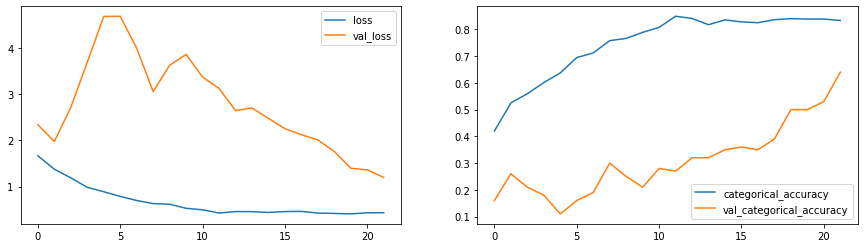

In [19]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy indicating that the model is not able to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [22]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_26 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_21 (Activation)  (None, 8, 50, 50, 32)    

In [24]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8026 - categorical_accuracy: 0.3665
Epoch 00001: saving model to model_init_2023-07-0912_37_36.422468/model-00001-1.80265-0.36652-1.86862-0.16000.h5
34/34 [==============================] - 149s 4s/step - loss: 1.8026 - categorical_accuracy: 0.3665 - val_loss: 1.8686 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1749 - categorical_accuracy: 0.5618
Epoch 00002: saving model to model_init_2023-07-0912_37_36.422468/model-00002-1.17490-0.56184-2.76638-0.17000.h5
34/34 [==============================] - 148s 4s/step - loss: 1.1749 - categorical_accuracy: 0.5618 - val_loss: 2.7664 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9345 - categorical_accuracy: 0.6463
Epoch 00003: saving model to model_init_2023-07-0912_37_36.422468/model-00003-0.93451-0.64630

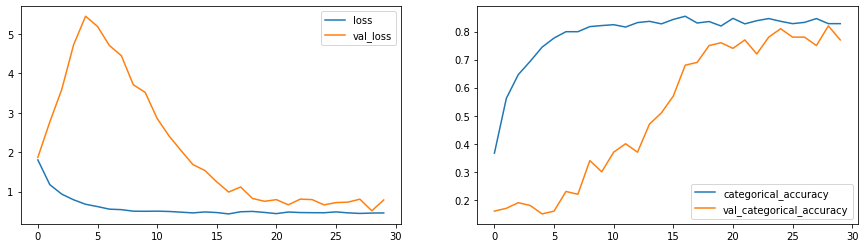

In [25]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 77%